<a href="https://colab.research.google.com/github/Jinhyungnam/Porject2/blob/main/traff_0530.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
_ = """
+ CutMix 

"""
# Test

In [ ]:
# traffic sign down
!gdown --id 1ysKr2SJAxGWrdSvoA5fn40jhRQmbPswl
!unzip data.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ysKr2SJAxGWrdSvoA5fn40jhRQmbPswl
To: /content/data.zip
100% 215M/215M [00:02<00:00, 98.3MB/s]
Archive:  data.zip
replace Train/0/00000_00000_00000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls

data.zip  sample_data  Test  Train


In [ ]:
# !ls

data  data.zip	sample_data


In [ ]:
# import os
# from os import listdir
# from os.path import isfile, join
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import cv2
# from PIL import Image
# from sklearn.metrics import f1_score
# from sklearn.utils.class_weight import compute_class_weight

# import tensorflow as tf
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# tf.__version__

'2.8.0'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/MyDrive/TA/{Set_Your_Path}')

In [ ]:
# Few imports

import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary
import time
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# Before starting, clear the memory

torch.cuda.empty_cache()

In [ ]:
# Define the transformations. To begin with, we shall keep it minimum - only resizing the images and converting them to PyTorch tensors

data_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
    ])

# # Define transformations

# test_transforms = transforms.Compose([
#     transforms.Resize([112, 112]),
#     transforms.ToTensor()
#     ])

In [ ]:
print(os.getcwd())
os.listdir()

/content


['.config', 'Train', 'Test', 'data.zip', 'sample_data']

In [ ]:
# Defining hyperparameters

BATCH_SIZE = 256
learning_rate = 0.001
EPOCHS = 15
numClasses = 43

In [ ]:
# Define path of training data

train_data_path = "./Train"
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)

# Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])

print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")

Number of training samples = 20808
Number of validation samples = 5202


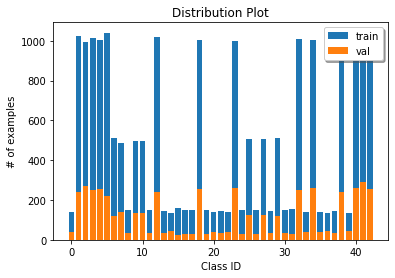

In [ ]:
# Plot histogram for training and validation data

train_hist = [0]*numClasses
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1
    
val_hist = [0]*numClasses
for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1

plt.bar(range(numClasses), train_hist, label="train")
plt.bar(range(numClasses), val_hist, label="val")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.savefig("train_val_split.png", bbox_inches = 'tight', pad_inches=0.5)

In [ ]:
# Create data loader for training and validation

train_loader = data.DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size = BATCH_SIZE)

In [ ]:
# Function to count the number of parameters in the model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:

import torch.nn as nn

class AlexnetTS(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, output_dim)
            )
        
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [ ]:
# Initialize the model
# The model is defined in the class AlexnetTS in the file class_alexnetTS.py

model = AlexnetTS(numClasses)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,063,891 trainable parameters


In [ ]:
# Define optimizer and criterion functions

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
# If CUDA is available, convert model and loss to cuda variables

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

# Print model
print(model)

AlexnetTS(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5,

In [ ]:
# Print summary of the model for the given dimension of the image

print(summary(model, (3, 112, 112))) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           1,792
         MaxPool2d-2           [-1, 64, 28, 28]               0
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4          [-1, 192, 28, 28]         110,784
         MaxPool2d-5          [-1, 192, 14, 14]               0
              ReLU-6          [-1, 192, 14, 14]               0
            Conv2d-7          [-1, 384, 14, 14]         663,936
              ReLU-8          [-1, 384, 14, 14]               0
            Conv2d-9          [-1, 256, 14, 14]         884,992
             ReLU-10          [-1, 256, 14, 14]               0
           Conv2d-11          [-1, 256, 14, 14]         590,080
        MaxPool2d-12            [-1, 256, 7, 7]               0
             ReLU-13            [-1, 256, 7, 7]               0
          Dropout-14                [-1

In [ ]:
# Print model's state dict

print("Model's state dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("")

Model's state dict:
features.0.weight 	 torch.Size([64, 3, 3, 3])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([192, 64, 3, 3])
features.3.bias 	 torch.Size([192])
features.6.weight 	 torch.Size([384, 192, 3, 3])
features.6.bias 	 torch.Size([384])
features.8.weight 	 torch.Size([256, 384, 3, 3])
features.8.bias 	 torch.Size([256])
features.10.weight 	 torch.Size([256, 256, 3, 3])
features.10.bias 	 torch.Size([256])
classifier.1.weight 	 torch.Size([1000, 12544])
classifier.1.bias 	 torch.Size([1000])
classifier.4.weight 	 torch.Size([256, 1000])
classifier.4.bias 	 torch.Size([256])
classifier.6.weight 	 torch.Size([43, 256])
classifier.6.bias 	 torch.Size([43])



In [ ]:
# Print optimizer details

print("Optimizer details:")
print(optimizer)
print("")

Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0
)



In [ ]:
# Function to calculate accuracy

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
# Function to perform training of the model

def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Train the model
    model.train()
    
    for (images, labels) in loader:
        images = images.cuda()
        labels = labels.cuda()
        
        # Training pass
        opt.zero_grad()
        
        output, _ = model(images)
        loss = criterion(output, labels)
        
        # Backpropagation
        loss.backward()
        
        # Calculate accuracy
        acc = calculate_accuracy(output, labels)
        
        # Optimizing weights
        opt.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
# Function to perform evaluation on the trained model

def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Evaluate the model
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in loader:
            images = images.cuda()
            labels = labels.cuda()
            
            # Run predictions
            output, _ = model(images)
            loss = criterion(output, labels)
            
            # Calculate accuracy
            acc = calculate_accuracy(output, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
# Perform training

# List to save training and val loss and accuracies
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS

for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_end_time = time.monotonic()

    val_start_time = time.monotonic()
    val_loss, val_acc = evaluate(model, val_loader, optimizer, criterion)
    val_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    val_loss_list[epoch] = val_loss
    val_acc_list[epoch] = val_acc
    
    print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
    print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
    print("")

Epoch-0: 
Training: Loss = 3.4741, Accuracy = 0.0617, Time = 24.93 seconds
Validation: Loss = 3.3029, Accuracy = 0.0784, Time = 4.59 seconds

Epoch-1: 


In [ ]:
# Saving the model

# Create folder to save model
MODEL_FOLDER = "../Model"
if not os.path.isdir(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)
    
PATH_TO_MODEL = MODEL_FOLDER + "/pytorch_classification_alexnetTS.pth"
if os.path.exists(PATH_TO_MODEL):
    os.remove(PATH_TO_MODEL)
torch.save(model.state_dict(), PATH_TO_MODEL)

print("Model saved at %s" %(PATH_TO_MODEL))

In [ ]:
# Plot loss and accuracies for training and validation data

_, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(train_loss_list, label="train")
axs[0].plot(val_loss_list, label="val")
axs[0].set_title("Plot - Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right', shadow=False)

# Accuracy plot
axs[1].plot(train_acc_list, label="train")
axs[1].plot(val_acc_list, label="val")
axs[1].set_title("Plot - Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right', shadow=True)

In [ ]:
data = []
labels = []

height = 30
width = 30
channels = 3
num_classes = 43

for i in range(num_classes) :
    path = f'./data/Train/{i}/'
    path = f'./Train/{i}/'
    Class = os.listdir(path)
    for a in Class:
        image = cv2.imread(path + a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((height, width))
        data.append(np.array(size_image))
        labels.append(i)

data = np.array(data)
labels = np.array(labels)

In [ ]:
data.shape

(26010, 30, 30, 3)

In [ ]:
labels.shape

(26010,)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)
from sklearn.linear_model import LinearRegression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
training_data = pd.read_csv('train_data.csv')
test_input_data = pd.read_csv('test_data.csv')

In [ ]:
# # Signal shift off
# train_x = np.array(training_data.values[:,3:], dtype=np.float64)
# train_y = np.array(training_data.values[:,2], dtype=np.float64)
# # test_x = np.array(test_input_data.values[:,18:], dtype=np.float64)
# test_x = np.array(test_input_data.values[:,2:], dtype=np.float64)

In [ ]:
# # Signal shift on
# cols = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16']
# for s in cols:
#     training_data['shf_{}'.format(s)] = training_data['{}'.format(s)].shift(-2000)
#     test_input_data['shf_{}'.format(s)] = test_input_data['{}'.format(s)].shift(-2000)
# training_data = training_data.dropna()
# test_input_data = test_input_data.fillna(0)

# train_x = np.array(training_data.values[:,19:], dtype=np.float64)
# train_y = np.array(training_data.values[:,2], dtype=np.float64)
# test_x = np.array(test_input_data.values[:,18:], dtype=np.float64)
# # test_x = np.array(test_input_data.values[:,2:], dtype=np.float64)

In [ ]:
train_x = np.array(training_data.values[:,3:], dtype=np.float64)
train_y = np.array(training_data.values[:,2], dtype=np.float64)
test_x = np.array(test_input_data.values[:,2:], dtype=np.float64)

In [ ]:
# # filtering on
# from scipy.signal import butter, filtfilt, square
# import matplotlib.pyplot as plt

# # b, a = butter(4, 0.0055/(100/2), btype='low', analog=False)  # fs = 100 Hz, fc = 0.005 Hz
# b, a = butter(4, 1/(100/2), btype='low', analog=False)  # fs = 100 Hz, fc = 1 Hz
# filt_train_data = np.array([filtfilt(b, a, train_x[:,i]) for i in range(len(train_x[0]))]).T
# train_x = filt_train_data
# filt_test_data = np.array([filtfilt(b, a, test_x[:,i]) for i in range(len(test_x[0]))]).T
# test_x = filt_test_data


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [ ]:
split_p = int(len(train_x)*0.2)

train1_x = train_x[:split_p*1,:] 
train2_x = train_x[split_p*2:,:] 
train_x_t = np.concatenate([train1_x,train2_x])
train_x_v = train_x[split_p*1:split_p*2,:]

train1_y = train_y[:split_p*1] 
train2_y = train_y[split_p*2:] 
train_y_t = np.concatenate([train1_y,train2_y],)
train_y_v = train_y[split_p*1:split_p*2]

In [ ]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(data[i:i+window_size+1])
        label_list.append(label[i:i+window_size])
    return np.array(feature_list), np.array(label_list)

def make_dataset2(data, window_size=20):
    feature_list = []
    for i in range(len(data) - window_size):
        feature_list.append(data[i:i+window_size+1])
    return np.array(feature_list)

In [ ]:
train_x_t_seq, train_y_t_seq = make_dataset(train_x_t, train_y_t, 30)
train_x_v_seq, train_y_v_seq = make_dataset(train_x_v, train_y_v, 30)
train_x_seq, train_y_seq = make_dataset(train_x, train_y, 30)

print(train_x_t_seq.shape)
print(train_y_t_seq.shape)
print(train_x_v_seq.shape)
print(train_y_v_seq.shape)
print(train_x_seq.shape)
print(train_y_seq.shape)

test_x_seq = make_dataset2(test_x, 30)
test_x_seq.shape

(2693257, 31, 16)
(2693257, 30)
(673291, 31, 16)
(673291, 30)
(3366578, 31, 16)
(3366578, 30)


(841623, 31, 16)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense , Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Dropout

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'):
    model_cnn =Sequential()
    # model_cnn.add(Conv1D(input_shape = (train_feature.shape[1], train_feature.shape[2]), 
    #                         filters=64,kernel_size=3,activation='relu'))
    model_cnn.add(Conv1D(input_shape = (train_x_t_seq.shape[1], train_x_t_seq.shape[2]), 
                            filters=64,kernel_size=3,activation='relu'))
    #model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling1D(pool_size = 2))
    # model_cnn.add(Dropout(0.25))


    model_cnn.add(Conv1D(filters=32,kernel_size=3,activation='relu'))
    #model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling1D(pool_size = 2))
    # model_cnn.add(Dropout(0.25))

    #model_cnn.add(Conv1D(filters=16,kernel_size=3,activation='relu'))
    #model_cnn.add(MaxPooling1D(pool_size = 2))
    #model_cnn.add(Dropout(0.25))

    model_cnn.add(Flatten())
    model_cnn.add(Dense(1000))
    # model_cnn.add(Dropout(0.25))
    model_cnn.add(Activation('relu'))

    model_cnn.add(Dense(1))
    model_cnn.add(Activation('linear'))
    model_cnn.summary()
    ###############3
    ################3
    import os
    model_cnn.compile(loss='mean_absolute_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=20)

    model_path = '/content/'
    filename = os.path.join(model_path, 'tmp_checkpoint_cnn_all_shft.h5')
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

    # history = model_cnn.fit(train_x_seq, train_y_seq,
    history = model_cnn.fit(train_x_t_seq, train_y_t_seq,
                                        epochs=1, 
                                        # epochs=200, 
                                        batch_size=16,
                                        validation_data=(train_x_v_seq, train_y_v_seq), 
                                        callbacks=[early_stop, checkpoint])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            3136      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 32)            6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 32)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 1000)              1

101672/168230 [=================>............] - ETA: 4:06 - loss: 13.4920

In [ ]:
model_cnn.load_weights(filename)
pred = model_cnn.predict(test_x_seq)
print(pred.shape)
print(pred.min(), pred.max())

(841623, 1)
-16.014948 533.835


In [ ]:
# def post_process_pred_ver2(y_pred, y_class_val_list):
#     """
#     use 'train_y' for 'y_class_val_list'
#     """
#     y_cls = np.sort(np.unique(y_class_val_list))
#     y_cls_mid = [(y_cls[i] + y_cls[i + 1])/2 for i in range(len(y_cls) - 1)]
#     y_pred_mapped = y_cls[np.searchsorted(y_cls_mid, y_pred)]
#     return y_pred_mapped

# pred2 = post_process_pred_ver2(pred, np.unique(train_y))


In [ ]:
# sample_submission = pd.read_csv('sample_solution.csv')
# pred = np.pad(pred, ((0,sample_submission.shape[0]-pred.shape[0]),(0,0)), 'constant', constant_values=0)

In [ ]:
# sample_submission['CO'] = pred
# sample_submission.to_csv('predicted_output.csv', index=False) 
# !kaggle competitions submit -c 2022-samsung-ds-competition-co-gas-data -f predicted_output.csv -m "Test"

In [ ]:
# print(pred3.min(), pred3.max())

In [ ]:
# len(np.unique(pred3))

In [ ]:
# np.unique(pred3)

In [ ]:
class Y_PRED_CLASSIFIER:
    def __init__(self, y_pred, y_real):
        self.y_pred_clf = self.create_y_pred_clf(y_pred, y_real)

    def create_y_pred_clf(self, y_pred, y_real):
        """
        """
        from sklearn.naive_bayes import GaussianNB
        y_pred_clf = GaussianNB().fit(y_pred.reshape(-1, 1), y_real.astype(str))
        return y_pred_clf

    def post_process_pred_ver4(self, y_pred):
        """
        y_pred_clf = create_y_pred_clf(y_pred, y_real):
        """
        y_pred_mapped = self.y_pred_clf.predict(y_pred.reshape(-1, 1)).astype(float)
        return y_pred_mapped
      

In [ ]:
pp = model_cnn.predict(train_x_seq)
pp2 = np.pad(pp, ((0,train_y.shape[0]-pp.shape[0]),(0,0)), 'constant', constant_values=0)
pp3 = np.squeeze(pp2)
y_pred_clf = Y_PRED_CLASSIFIER(pp3, train_y) ## create y pred clf 
y_pred = y_pred_clf.post_process_pred_ver4(pred)  # using y pred clf

In [ ]:
sample_submission = pd.read_csv('sample_solution.csv')

In [ ]:
y_pred2 = np.pad(y_pred, ((0,sample_submission.shape[0]-y_pred.shape[0])), 'constant', constant_values=0)

In [ ]:
sample_submission['CO'] = y_pred2  #pred3
sample_submission.to_csv('predicted_output.csv', index=False) 
!kaggle competitions submit -c 2022-samsung-ds-competition-co-gas-data -f predicted_output.csv -m "Test"

100% 10.3M/10.3M [00:02<00:00, 4.77MB/s]
Successfully submitted to 2022 Samsung DS competition - CO gas data

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_pred2)
plt.show()

In [ ]:
plt.hist(pred)
plt.show()

In [ ]:
# multioutputregressor = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
#               max_depth = 10, alpha = 10, n_estimators = 100, eval_metric='mae')
# multioutputregressor.fit(x_train, y_train
#                       ,eval_set=[(x_test, y_test)],
#                        early_stopping_rounds = 10, eval_metric='mae')

In [ ]:
np.unique(train_y)

In [ ]:
#######################여기까지

In [ ]:
import datetime
print(datetime.datetime.now())